In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
df = pd.read_csv('data/SHEL_data.csv')

In [4]:
df = df.sort_values("Date").reset_index(drop=True)

In [5]:
feature_cols = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]

In [6]:
data = df[feature_cols].values.astype(np.float32)

In [7]:
N = len(data)
print("Total points:", N)

Total points: 977


In [8]:
split_idx = int(0.9 * N)
print("Train until index:", split_idx, "Test from index:", split_idx)

Train until index: 879 Test from index: 879


In [9]:
scaler = StandardScaler()
scaler.fit(data[:split_idx])
data_scaled = scaler.transform(data).astype(np.float32)

In [12]:
SEQ_LEN = 60
N_FUTURE = 1
TARGET_DIM = 6

In [13]:
def make_window_indices(num_points, seq_len, n_future, split_idx):
    max_start = num_points - seq_len - n_future + 1
    train_idx, test_idx = [], []

    for i in range(max_start):
        target_t = i + seq_len
        if target_t < split_idx:
            train_idx.append(i)
        else:
            test_idx.append(i)
    return train_idx, test_idx

In [14]:
train_starts, test_starts = make_window_indices(N, SEQ_LEN, N_FUTURE, split_idx)
print(len(train_starts), "train windows,", len(test_starts), "test windows")

819 train windows, 98 test windows


In [15]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data_scaled, starts, seq_len):
        self.data = data_scaled
        self.starts = starts
        self.seq_len = seq_len
    def __len__(self):
        return len(self.starts)
    def __getitem__(self, idx):
        i = self.starts[idx]
        x = self.data[i : i + self.seq_len]
        y = self.data[i + self.seq_len]
        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y).float().unsqueeze(0)
        return x, y

In [16]:
train_ds = TimeSeriesDataset(data_scaled, train_starts, SEQ_LEN)
test_ds  = TimeSeriesDataset(data_scaled, test_starts,  SEQ_LEN)

In [17]:
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, drop_last=False)

In [18]:
class AttentiveRNNForecaster(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers,
                 n_future, target_dim, num_heads=4, attn_dropout=0.1):
        super().__init__()
        self.n_future = n_future
        self.target_dim = target_dim
        self.rnn = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
        )
        self.attn = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=num_heads,
            dropout=attn_dropout,
            batch_first=True,
        )
        self.head = nn.Linear(hidden_size, n_future * target_dim)
    def forward(self, x):
        B, T, _ = x.shape
        h, _ = self.rnn(x)
        attn_out, attn_weights = self.attn(h, h, h)
        last_ctx = attn_out[:, -1, :]
        out = self.head(last_ctx)
        out = out.view(B, self.n_future, self.target_dim)
        return out, attn_weights

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
model = AttentiveRNNForecaster(
    input_size=6,
    hidden_size=64,
    n_layers=1,
    n_future=1,
    target_dim=6,
    num_heads=4
).to(device)

In [21]:

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [22]:
EPOCHS = 30
for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred, _ = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_ds)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred, _ = model(xb)
            test_loss += loss_fn(pred, yb).item() * xb.size(0)
    test_loss /= len(test_ds)
    print(f"Epoch {epoch:03d} | Train MSE: {train_loss:.6f} | Test MSE: {test_loss:.6f}")

Epoch 001 | Train MSE: 0.695430 | Test MSE: 0.522691
Epoch 002 | Train MSE: 0.273714 | Test MSE: 0.293056
Epoch 003 | Train MSE: 0.217818 | Test MSE: 0.293280
Epoch 004 | Train MSE: 0.214734 | Test MSE: 0.307550
Epoch 005 | Train MSE: 0.213400 | Test MSE: 0.308504
Epoch 006 | Train MSE: 0.207462 | Test MSE: 0.347893
Epoch 007 | Train MSE: 0.190064 | Test MSE: 0.304825
Epoch 008 | Train MSE: 0.200712 | Test MSE: 0.346364
Epoch 009 | Train MSE: 0.197622 | Test MSE: 0.301759
Epoch 010 | Train MSE: 0.196957 | Test MSE: 0.278019
Epoch 011 | Train MSE: 0.194050 | Test MSE: 0.308231
Epoch 012 | Train MSE: 0.190619 | Test MSE: 0.351443
Epoch 013 | Train MSE: 0.194433 | Test MSE: 0.348537
Epoch 014 | Train MSE: 0.184810 | Test MSE: 0.336852
Epoch 015 | Train MSE: 0.176093 | Test MSE: 0.322828
Epoch 016 | Train MSE: 0.169972 | Test MSE: 0.327978
Epoch 017 | Train MSE: 0.162535 | Test MSE: 0.358949
Epoch 018 | Train MSE: 0.160921 | Test MSE: 0.353396
Epoch 019 | Train MSE: 0.161240 | Test MSE: 0.

In [23]:
model.eval()
preds_scaled = []
trues_scaled = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        pred, _ = model(xb)
        preds_scaled.append(pred.cpu().numpy())
        trues_scaled.append(yb.numpy())
preds_scaled = np.concatenate(preds_scaled, axis=0)[:, 0, :]
trues_scaled = np.concatenate(trues_scaled, axis=0)[:, 0, :]

In [24]:
def invert_batch(scaled_batch):
    dummy = np.zeros((len(scaled_batch), 6), dtype=np.float32)
    dummy[:] = scaled_batch
    inv = scaler.inverse_transform(dummy)
    return inv

In [25]:
preds = invert_batch(preds_scaled)
trues = invert_batch(trues_scaled)

6

In [29]:
preds_scaled = np.concatenate(preds_scaled, axis=0)[:, 0, :]
trues_scaled = np.concatenate(trues_scaled, axis=0)[:, 0, :]

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [30]:
feature_cols = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
scaler

,copy,True
,with_mean,True
,with_std,True


In [31]:
def invert_scaled_batch(scaled_batch, scaler):
    # scaled_batch: [N, 6]
    # put into dummy array so inverse_transform works on all 6 features at once
    dummy = np.zeros_like(scaled_batch, dtype=np.float32)
    dummy[:] = scaled_batch
    return scaler.inverse_transform(dummy)

preds = invert_scaled_batch(preds_scaled, scaler)   # [N_test, 6]
trues = invert_scaled_batch(trues_scaled, scaler)

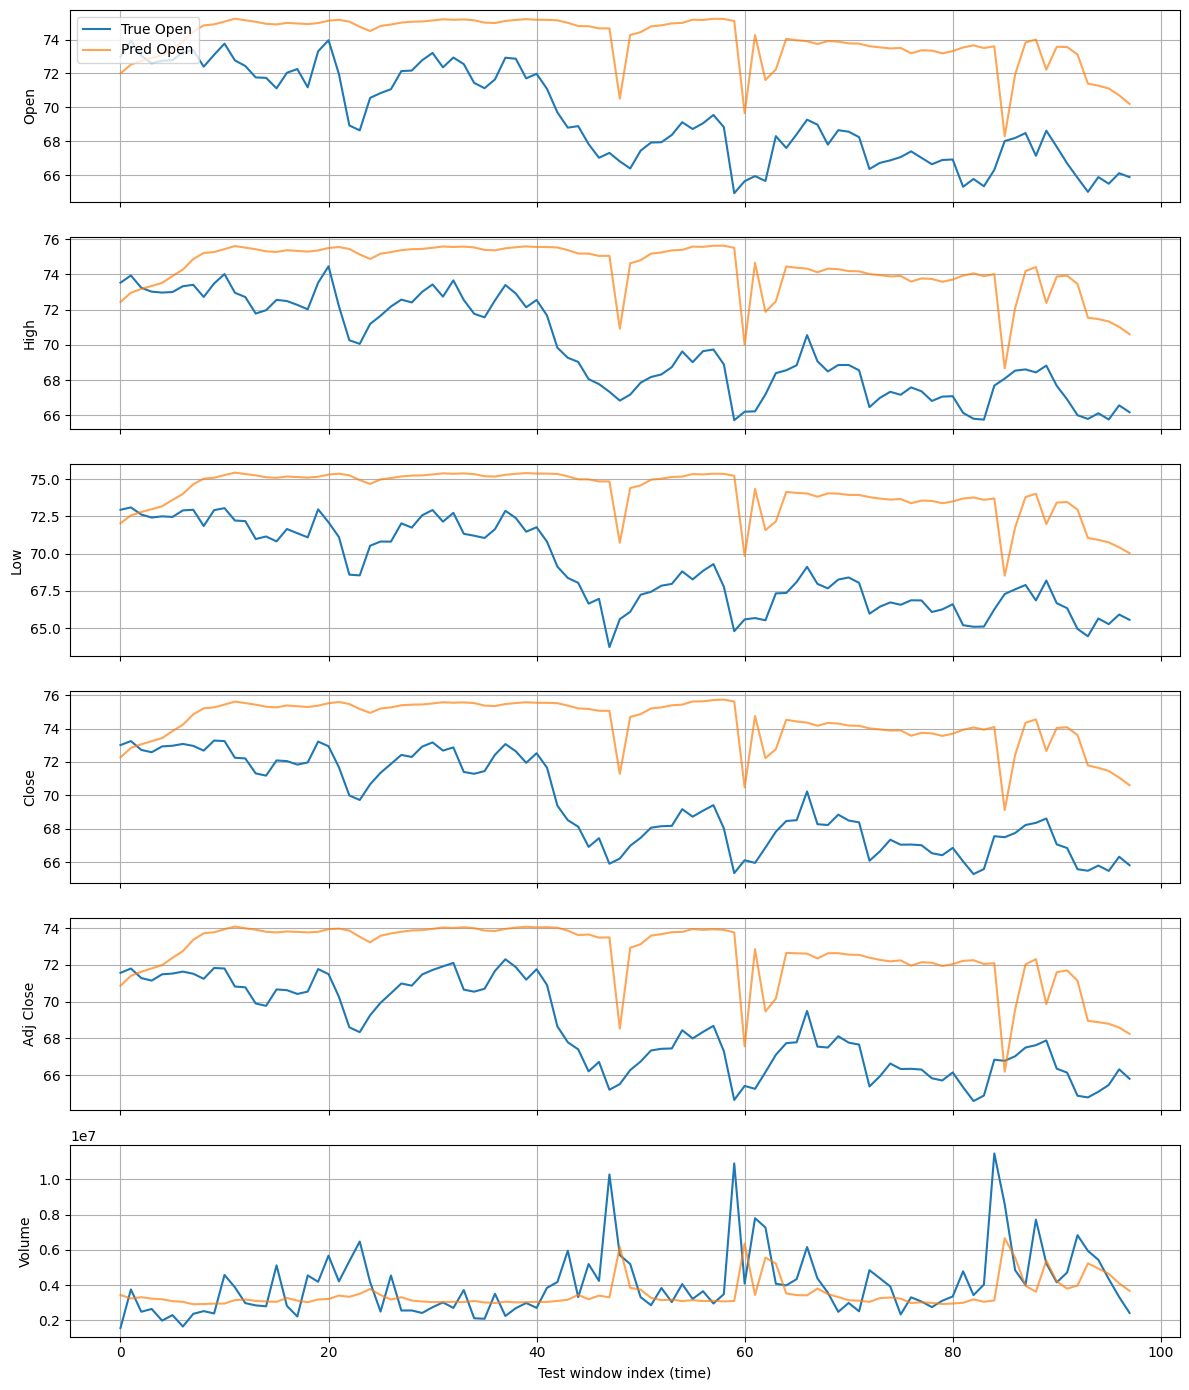

In [32]:
import matplotlib.pyplot as plt

timesteps = np.arange(preds.shape[0])

fig, axes = plt.subplots(6, 1, figsize=(12, 14), sharex=True)

for i, col in enumerate(feature_cols):
    ax = axes[i]
    ax.plot(timesteps, trues[:, i], label=f"True {col}")
    ax.plot(timesteps, preds[:, i], label=f"Pred {col}", alpha=0.7)
    ax.set_ylabel(col)
    ax.grid(True)
    if i == 0:
        ax.legend(loc="upper left")

axes[-1].set_xlabel("Test window index (time)")
plt.tight_layout()
plt.show()

In [33]:
preds   # shape [N_test, 6]
trues   # shape [N_test, 6]
feature_cols = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]

In [34]:

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# RMSE for each of the 6 features
feature_rmses = {}

for i, col in enumerate(feature_cols):
    feature_rmses[col] = rmse(trues[:, i], preds[:, i])

# Overall RMSE (across all features)
overall_rmse = rmse(trues, preds)

print("RMSE per feature:")
for col, val in feature_rmses.items():
    print(f"{col:10s}: {val:.4f}")

print("\nOverall RMSE (all 6 dims combined):", round(overall_rmse, 4))

RMSE per feature:
Open      : 5.1189
High      : 5.0589
Low       : 5.6273
Close     : 5.4637
Adj Close : 4.5753
Volume    : 1828774.5000

Overall RMSE (all 6 dims combined): 746594.1


In [35]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

print("Scaled RMSE per feature:")
for i, col in enumerate(feature_cols):
    print(f"{col:10s}: {rmse(trues_scaled[:, i], preds_scaled[:, i]):.4f}")

overall_rmse_scaled = rmse(trues_scaled, preds_scaled)
print("\nOverall Scaled RMSE:", overall_rmse_scaled)

Scaled RMSE per feature:
Open      : 0.5103
High      : 0.5051
Low       : 0.5618
Close     : 0.5455
Adj Close : 0.4196
Volume    : 1.0832

Overall Scaled RMSE: 0.64268154


In [36]:
preds[0]

array([7.2001381e+01, 7.2434227e+01, 7.2035683e+01, 7.2273392e+01,
       7.0864365e+01, 3.4411548e+06], dtype=float32)

In [ ]:
preds[1]